# Explainer notebook for Copenhagen visualizations by Jamie and Valentin

Below is the code and some static graphs used for processing the data used in our project for exploring the city of Copenhagen.
The code is split into the sections that roughly corresponds to the website.

N.B. the code will generate files from the relative path "src/data/" so remember to have the whole project folder downloaded to avoid errors.

## Imports, setup and Introduction
We'll import a data set here that is based on peoples age, their income and the district they live in.

In [1]:
import os, collections, csv
import pandas as pd, matplotlib as mat, matplotlib.pyplot as plt
root_directory = os.path.abspath(os.pardir)
df = pd.read_csv(os.path.join(root_directory, "src","data","kon_alder_bydel_penge.csv"), encoding="utf-8") # reads csv

# Show number of people in each district
print df.groupby(['Bydel'])['Personer'].sum()

Bydel
Amager Vest       52415
Amager Øst        45863
Bispebjerg        44857
Brønshøj-Husum    34166
Indre By          43492
Nørrebro          65847
Valby             41930
Vanløse           32494
Vesterbro         50292
Østerbro          61935
Name: Personer, dtype: int64


Looks good.
We know that there are many tall buildings on Nørrebro and more villas and Brønshøj-Husum

Moving on

## People in age groups listed by districts
Let's try to see the distribution here.
A lot of data processing to calculate the ratio between age groups in different districts.

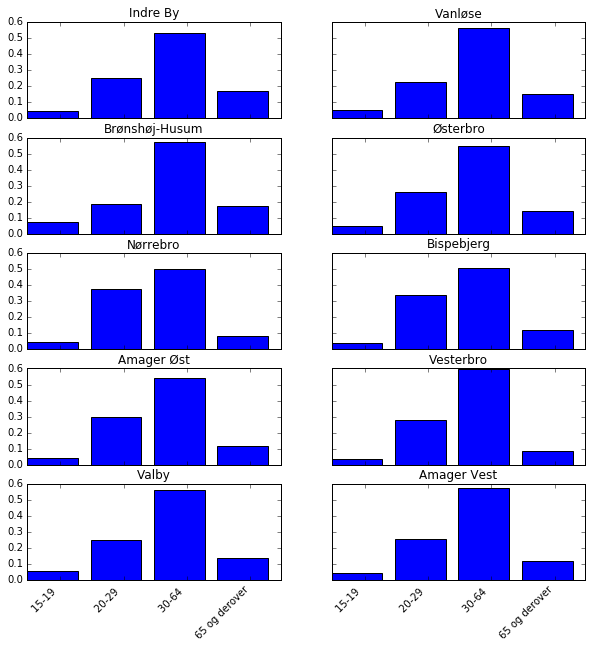

In [2]:
%matplotlib inline
# -*- coding: utf-8 -*-

Districts = df.Bydel.unique()
age_categories = df.Aldersgruppe.unique()

# Total number of people, and people in an age category
total_people = df['Personer'].sum()
people_in_age_category = df.groupby(['Aldersgruppe'])['Personer'].sum().astype(float)

# Create dictionary with ratios
age_category_sum = []
for category in age_categories:
    age_category_sum.append((category, (people_in_age_category[category] / total_people)))
age_category_sum_dict = dict(age_category_sum)


# Three subplots sharing both x/y axes
f, axarr = plt.subplots(5,2, sharey=True, sharex=True, figsize=(10,10))

# Loop through districts and calculate ratio of people living in a district by their age category
index = 0
jj = 0
people_in_districts_as_ratio = {}
for district in Districts:
    people_in_districts_as_ratio[district] = {}
    people_in_district = df[df['Bydel'].isin([district])].groupby(['Aldersgruppe'])['Personer'].sum().astype(float)
    total_people_in_district = people_in_district.sum()
    for category in age_categories:
        try:
            people_in_districts_as_ratio[district][category] = (people_in_district[category] / total_people_in_district)
        except KeyError:
            people_in_districts_as_ratio[district][category] = 0
    
    d_temp = collections.OrderedDict(sorted(people_in_districts_as_ratio[district].items()))
    axarr[index%5, index%2].set_title(district)
    h = axarr[index%5, index%2].bar(range(len(d_temp)), d_temp.values(), color="blue")

    index += 1
    
# Fine-tune figure; make subplots close to each other and hide x ticks for
# all but bottom plot.
f.subplots_adjust(hspace=0.2)
plt.sca(axarr[0, 1])
plt.xticks(rotation=90)
for ax in f.axes:
    mat.pyplot.sca(ax)
    xticks_pos = [0.65*patch.get_width() + patch.get_xy()[0] for patch in h]
    plt.xticks(xticks_pos, age_categories,  ha='right', rotation=45)

# Show the plots!
plt.show()



Okay so we can see here that the age group _30-64 years_ is the highest represented (but also the one spanning the most years, except for _65 and above_, unless we take average length of human lives into account).

Furthermore the distribution looks pretty consistent on all the city districts. There are only slight variations visually noticeable.
E.g. _Nørrebro_ has a lot of people in the _20-29 years_ group compared to _Brønshøj-Husum_ which has a lot fewer. Actually the ratio of _20-29 years_ old is twice as high on _Nørrebro_ than it is in _Brønshøj-Husum_.


In [3]:
# We'll just create a file here to plot the ratios on the webpage
data = pd.DataFrame(people_in_districts_as_ratio)
data.to_csv("personeriprocent.csv", sep=',', encoding="utf-8")

## Average income by district
We could look at the income by age category as well, but we all probably know how that one will look.

Instead let's take a look at the distribution between the different districts.

This is much like the previous code. Slight alterations have been made to account for the new category we're looking at

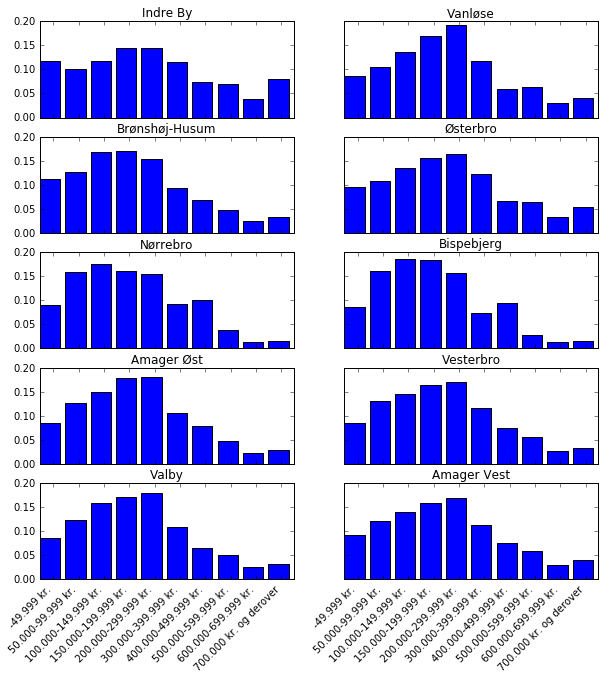

In [4]:
# Create list of categories
income_categories = df.Brutto.unique()

# Three subplots sharing both x/y axes
f, axarr = plt.subplots(5,2, sharey=True, sharex=True, figsize=(10,10))

# Loop through districts and calculate ratio of people living in a district by their age category
index = 0
jj = 0
temp = {}
for district in Districts:
    temp[district] = {}
    income_in_district = df[df['Bydel'].isin([district])].groupby(['Brutto'])['Personer'].sum().astype(float)
    total_people_district = income_in_district.sum()
    for category in income_categories:
        try:
            temp[district][category] = income_in_district[category] / total_people_district
        except KeyError:
            temp[district][category] = 0
    
    d_temp = collections.OrderedDict(sorted(temp[district].items()))
    axarr[index%5, index%2].set_title(district)
    h = axarr[index%5, index%2].bar(range(len(d_temp)), d_temp.values(), color="blue")

    index += 1

# Fine-tune figure; make subplots close to each other and hide x ticks for
# all but bottom plot.
f.subplots_adjust(hspace=0.2)
plt.sca(axarr[0, 1])
plt.xticks(rotation=90)
for ax in f.axes:
    mat.pyplot.sca(ax)
    xticks_pos = [0.65*patch.get_width() + patch.get_xy()[0] for patch in h]
    plt.xticks(xticks_pos, income_categories,  ha='right', rotation=45)

# Show the plots!
plt.show()

At a first glance it looks normally distributed with a positive skew for most of the districts.
There is though a huge difference between the wealthiest and the poorest districts. 
Let's try to see the same chart with only the 3 highest income intervals

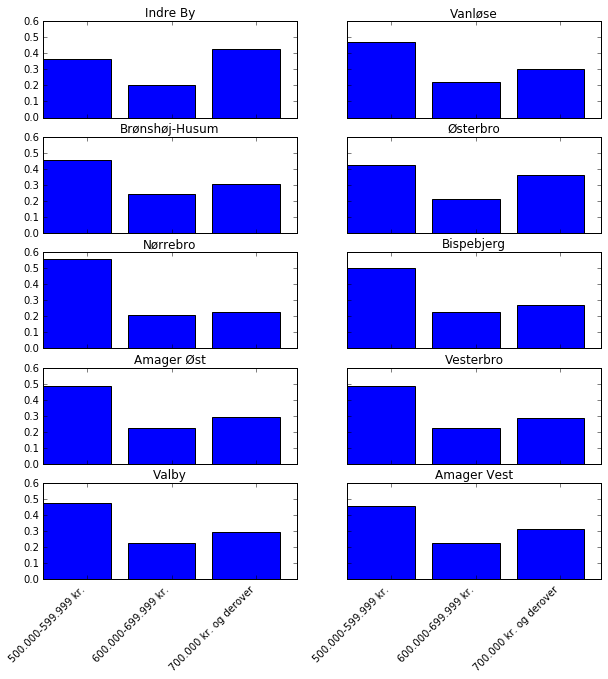

In [5]:
# Create list of categories
income_categories = df.Brutto.unique()[-3:]


# Three subplots sharing both x/y axes
f, axarr = plt.subplots(5,2, sharey=True, sharex=True, figsize=(10,10))

# Loop through districts and calculate ratio of people living in a district by their age category
index = 0
jj = 0
temp = {}
for district in Districts:
    temp[district] = {}
    income_in_district = df[((df.Kategori == 8) 
                   | (df.Kategori == 9)
                   | (df.Kategori == 10))
                   & df['Bydel'].isin([district])].groupby(['Brutto'])['Personer'].sum().astype(float)
    total_people_district = income_in_district.sum()
    for category in income_categories:
        try:
            temp[district][category] = income_in_district[category] / total_people_district
        except KeyError:
            temp[district][category] = 0
    
    d_temp = collections.OrderedDict(sorted(temp[district].items()))
    axarr[index%5, index%2].set_title(district)
    h = axarr[index%5, index%2].bar(range(len(d_temp)), d_temp.values(), color="blue")

    index += 1

# Fine-tune figure; make subplots close to each other and hide x ticks for
# all but bottom plot.
f.subplots_adjust(hspace=0.2)
plt.sca(axarr[0, 1])
plt.xticks(rotation=90)
for ax in f.axes:
    mat.pyplot.sca(ax)
    xticks_pos = [0.65*patch.get_width() + patch.get_xy()[0] for patch in h]
    plt.xticks(xticks_pos, income_categories,  ha='right', rotation=45)

# Show the plots!
plt.show()

# Summing up
Okay let's calculate some descriptive statistics about our population.
We will calculate the mean and median for Copenhagen as well as for the individual districts.
To do this we must first assume that the data is uniformly distributed within our bucket categories.
We use the following formula to calculate the median
$$ L_m + \left [ \frac { \frac{N}{2} - F_{m-1} }{f_m} \right ] \cdot c $$

And to calculate the mean $\mu$ we simply calculate the mean $\mu_2$ of an interval and use that to calculate $\mu$.

According to Danmarks Statistik (DST) the mean income in Copenhagen is $261.882$ DKK, and the mean age is $35,9$ years old

In [6]:
people_sum_income = df.groupby(['Brutto'])['Personer'].sum().astype(float)
people_sum_age = df.groupby(['Aldersgruppe'])['Personer'].sum().astype(float)
#Lm is the lower class boundary of the group containing the median
#n is the total number of values
#Fm_old is the cumulative frequency of the groups before the median group
#Fm is the frequency of the median group
#c is the group width
income_category_list = [
    (0,49999),
    (50000,99999),
    (100000,149999),
    (150000,199999),
    (200000,299999),
    (300000,399999),
    (400000,499999),
    (500000,599999),
    (600000,699999),
    (700000,1000000) # Larger interval here to "capture" more of the incomes above 700.000
]
age_category_list = [
        (15,19),
        (20,29),
        (30,64),
        (65,80) # Interval goes up to average lifespan in Denmark
]

def median(data, category):
    result = 0
    N = data.sum()
    Median_group = N/2
    Lm = 0
    c = 0
    fm = 0
    Fm_old = 0
    cumsum = 0
    index = 0
    for ii in data:
        cumsum = ii + cumsum
        if cumsum >= Median_group: # find the median group so we calculate the median for the right group
            Lm = category[index][0]
            c = category[index][1] - category[index][0]
            fm = ii
            result = Lm + ((N/2 - Fm_old)/fm) * c
            break
        Fm_old = Fm_old + ii
        index = index+1
        
    return result    
        

income_category_mean = [
        (0+49999)/2.0,
        (50000+99999)/2.0,
        (100000+149999)/2.0,
        (150000+199999)/2.0,
        (200000+299999)/2.0,
        (300000+399999)/2.0,
        (400000+499999)/2.0,
        (500000+599999)/2.0,
        (600000+699999)/2.0,
        (700000+300000)/1.0
]
age_category_mean = [
        (15+19)/2.0,
        (20+29)/2.0,
        (30+64)/2.0,
        (65+80)/2.0
]
def mean(data, category):
    people_sum_total = data.sum()
    
    mean_list = [y*x for x,y in zip(category, data.values)]
    mu = (sum(mean_list))/(people_sum_total)
    return mu

print 'Copenhagen'
print '-' * len('Copenhagen')
print 'median income: {0:.0f} DKK'.format(median(people_sum_income, income_category_list))
print 'mean income: {0:.0f} DKK'.format(mean(people_sum_income,income_category_mean))
print 'median age: {0:.2f} years'.format(median(people_sum_age, age_category_list))
print 'mean age: {0:.2f} years'.format(mean(people_sum_age,age_category_mean))



Copenhagen
----------
median income: 188987 DKK
mean income: 255109 DKK
median age: 40.75 years
mean age: 42.50 years


We see that the calculated mean income for Copenhagen is $255.109$ DKK which is only a $2,6\%$ deviation from the statistics from DST.
The situation is a bit different for the mean age, calculated to be $42,5$ years deviates $16,8\%$ from the DST statistics. It is due to the assumption about the data being uniformly distributed and setting the maximum of the last interval to the expected lifespan when we know there are fewer people who are $80$ years old than there are people that are $60$ years old.
There is no data we can hold the calculated medians up against, but they seem reasonable as we might expect extreme values to not have as big an influence on the median.

In [15]:
from prettytable import PrettyTable
my_dict = {}
table = PrettyTable()
# calculate means and medians again for all districts
table.field_names = ["District", "Mean Income", "Median Income", "Mean Age", "Median Age"]
for district in Districts:
    people_sum_age = df[df['Bydel'] == district].groupby(['Aldersgruppe'])['Personer'].sum().astype(float)
    people_sum_income = df[df['Bydel'] == district].groupby(['Brutto'])['Personer'].sum().astype(float)
    my_dict[district] = [
        "{0:.0f}".format(mean(people_sum_income,income_category_mean)),
        "{0:.0f}".format(median(people_sum_income, income_category_list)),
        "{0:.0f}".format(mean(people_sum_age,age_category_mean)),
        "{0:.0f}".format(median(people_sum_age, age_category_list))
    ]
    table.add_row([district, my_dict[district][0], my_dict[district][1], my_dict[district][2], my_dict[district][3]])
       

print table.get_string(sortby="Mean Income")

+----------------+-------------+---------------+----------+------------+
|    District    | Mean Income | Median Income | Mean Age | Median Age |
+----------------+-------------+---------------+----------+------------+
|   Bispebjerg   |    217347   |     168333    |    41    |     38     |
|    Nørrebro    |    226183   |     173703    |    39    |     35     |
| Brønshøj-Husum |    241220   |     177383    |    45    |     44     |
|   Amager Øst   |    246835   |     188885    |    42    |     40     |
|     Valby      |    249359   |     188405    |    43    |     42     |
|   Vesterbro    |    256171   |     193050    |    42    |     40     |
|  Amager Vest   |    265596   |     196465    |    43    |     42     |
|    Vanløse     |    267543   |     202155    |    44    |     43     |
|    Østerbro    |    280601   |     204194    |    43    |     42     |
|    Indre By    |    303568   |     214628    |    44    |     43     |
+----------------+-------------+---------------+---

We can clearly see a difference in the different districts. For example
_Brønshøj_ has the highest mean age at $45,0$ years
_Nørrebro_ has the lowest at $39,3$ years.
_Bispebjerg_ has the lowest mean income and _Indre By_ has the highest with a $33.1\%$ difference.


# Decisions, decisions, decisions
Time to look at some decision trees

In [8]:
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn import tree
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.externals.six import StringIO
from sklearn.preprocessing import Imputer
import pydot
from IPython.display import Image

# load in datasets
df_KABP = pd.read_csv(os.path.join(root_directory, "src","data","kon_alder_bydel_penge.csv")) # reads csv
df_KABP_repeated = df_KABP.loc[df_KABP.index.repeat(df_KABP['Personer'])].copy().reset_index(drop=True)

df_BEA = pd.read_csv(os.path.join(root_directory, "src","data","boliger_ejerforhold_areal.csv")) # reads csv
df_BEA_repeated = df_BEA.loc[df_BEA.index.repeat(df_BEA['Antal boliger'])].copy().reset_index(drop=True)

df_AHU = pd.read_csv(os.path.join(root_directory, "src","data","Alder_herkomst_uddanelse.csv")) # reads csv
df_AHU_repeated = df_AHU.loc[df_AHU.index.repeat(df_AHU['Personer'])].copy().reset_index(drop=True)


df_CB = pd.read_csv(os.path.join(root_directory, "src","data","civilstatus_born.csv")) # reads csv
df_CB_repeated = df_CB.loc[df_CB.index.repeat(df_CB['Antal'])].copy().reset_index(drop=True)
def createDT (data, target):
    
    vectorizer = DV( sparse = False )
    train_dict = data.T.to_dict().values()
    X = vectorizer.fit_transform(train_dict)
    X_train, X_test, target_train, target_test = train_test_split( X, target, test_size=0.1)

    clf = tree.DecisionTreeClassifier(max_depth=3)
    clf = clf.fit(X_train, target_train)


    print clf.score(X_test, target_test, sample_weight=None)
    return clf, vectorizer, target.unique()
ctf_civil, vec4,  label4 = createDT(df_CB_repeated[['Born', 'Famtype']], df_CB_repeated['Bydel'])
ctf_person, vec2, label2 = createDT(df_KABP_repeated[['Kategori', 'Aldersgruppe']], df_KABP_repeated['Bydel'])
ctf_person2, vec3, label1  = createDT(df_AHU_repeated[['Gruppe', 'Uddannelseskategori', 'Herkomst']], df_AHU_repeated['Bydel'])
ctf_bolig, vec1, label1 = createDT(df_BEA_repeated[['EJERFORHOLD', 'SAMAREAL']], df_BEA_repeated['Bydel'])

0.147424560628
0.159137967462
0.148182182324
0.17557001117


In [9]:

test = pd.read_csv(os.path.join(root_directory, "notebooks","mig.csv"))
def accumulateProba(ctf_bolig, ctf_person, ctf_person2, ctf_civil, vec1, vec2, vec3, vec4, persons):
    mitHjem = persons[['EJERFORHOLD', 'SAMAREAL']].T.to_dict().values()

    mig = persons[['Kategori', 'Aldersgruppe']].T.to_dict().values()

    mereMig = persons[['Gruppe', 'Uddannelseskategori', 'Herkomst']].T.to_dict().values()

    migOgDig = persons[['Born', 'Famtype']].T.to_dict().values()

    X1 = vec1.transform(mitHjem)
    X2 = vec2.transform(mig)
    X3 = vec3.transform(mereMig)
    X4 = vec4.transform(migOgDig)
    answer1 = ctf_bolig.predict_proba(X1)
    answer2 = ctf_person.predict_proba(X2)
    answer3 = ctf_person2.predict_proba(X3)
    answer4 = ctf_civil.predict_proba(X4)
    answers = answer1 + answer2 + answer3 + answer4
    index = [np.argmax(x) for x in answers]
    result = []
    for i in index:
        result.append(ctf_bolig.classes_[i])
    return result
print accumulateProba(ctf_bolig, ctf_person, ctf_person2, ctf_civil, vec1, vec2, vec3, vec4, test)

['N\xc3\xb8rrebro', 'N\xc3\xb8rrebro', '\xc3\x98sterbro']


In [10]:
def Vote (ctf_bolig, ctf_person, ctf_person2, ctf_civil, vec1, vec2, vec3, vec4, persons):
    mitHjem = persons[['EJERFORHOLD', 'SAMAREAL']].T.to_dict().values()
    mig = persons[['Kategori', 'Aldersgruppe']].T.to_dict().values()
    mereMig = persons[['Gruppe', 'Uddannelseskategori', 'Herkomst']].T.to_dict().values()
    migOgDig = persons[['Born', 'Famtype']].T.to_dict().values()
    X1 = vec1.transform(mitHjem)
    X2 = vec2.transform(mig)
    X3 = vec3.transform(mereMig)
    X4 = vec4.transform(migOgDig)
    answers = list()
    answers.append(ctf_bolig.predict(X1))
    answers.append(ctf_person.predict(X2))
    answers.append(ctf_person2.predict(X3))
    answers.append(ctf_civil.predict(X4))
    votes = []
    for i in np.arange(len(answers[0])):
        vote = {}
        for answer in answers:
            if(answer[i] in vote.keys()):
                vote[answer[i]] = vote[answer[i]]+1
            else:
                vote[answer[i]] = 1
        votes.append(max(vote, key=vote.get))
    return votes
print Vote (ctf_bolig, ctf_person, ctf_person2, ctf_civil, vec1, vec2, vec3, vec4, test)
        

['N\xc3\xb8rrebro', 'N\xc3\xb8rrebro', 'N\xc3\xb8rrebro']


In [13]:
dot_data = StringIO()
tree.export_graphviz(ctf_bolig, out_file=dot_data,  
                         feature_names=vec1.get_feature_names(),  
                         class_names=ctf_bolig.classes_,  
                         filled=True, rounded=True,
                         special_characters=True)
graph = pydot.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())
def get_code(tree, feature_names):
        left      = tree.tree_.children_left
        right     = tree.tree_.children_right
        threshold = tree.tree_.threshold
        features  = [feature_names[i] for i in tree.tree_.feature]
        value = tree.tree_.value

        def recurse(left, right, threshold, features, node):
                if (threshold[node] != -2):
                        print "if ( " + features[node] + " <= " + str(threshold[node]) + " ) {"
                        if left[node] != -1:
                                recurse (left, right, threshold, features,left[node])
                        print "} else {"
                        if right[node] != -1:
                                recurse (left, right, threshold, features,right[node])
                        print "}"
                else:
                        print "return " + str(value[node])

        recurse(left, right, threshold, features, 0)

In [14]:
get_code(ctf_bolig, vec1.get_feature_names())

if ( EJERFORHOLD=Almennyttigt boligbyggeri <= 0.5 ) {
if ( EJERFORHOLD=Ejerbolig <= 0.5 ) {
if ( SAMAREAL=120 m2 og derover <= 0.5 ) {
return [[ 14662.  15783.  14765.   4654.  13774.  23658.  12137.   9702.  17179.
   22235.]]
} else {
return [[ 1396.   739.   380.   216.  4321.  2038.   661.   492.  1804.  3314.]]
}
} else {
if ( SAMAREAL=40 - 59 m2 <= 0.5 ) {
return [[ 7425.  5043.  2112.  4985.  5699.  2041.  5086.  4829.  3716.  6158.]]
} else {
return [[  419.  1482.   592.   343.   603.  1000.   775.   732.   827.   988.]]
}
}
} else {
if ( SAMAREAL=80 - 99 m2 <= 0.5 ) {
if ( SAMAREAL=Under 40 m2 <= 0.5 ) {
return [[ 4022.  2615.  7007.  4811.   603.  4290.  4118.  1606.  4723.  3100.]]
} else {
return [[ 941.  155.   84.  286.  145.  519.  132.  111.  263.  172.]]
}
} else {
return [[ 2144.  1150.  1507.  2805.   495.  3425.  1297.   799.   869.   980.]]
}
}
